In [275]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, interpolate
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from ADM import ADM
from sklearn.feature_selection import mutual_info_regression
from scipy.fft import fft, fftfreq

from mutual_information import create_spectrogram, compute_mutual_information

sns.set()

In [265]:
def exp_decaying_filter(tau):
    return np.exp(-np.arange(0, tau * 5, 1 / 64) / tau) / tau

def reconstruct_from_spikes(spikes, length, spike_value, use_exponential=False, tau=0.1):
    reconstructed_signal = np.zeros(length)
    spikes_sampling_rate_indices = (spikes * 64).astype(int)
    reconstructed_signal[spikes_sampling_rate_indices] = spike_value
    
    if use_exponential:
        reconstructed_signal = signal.convolve(reconstructed_signal, exp_decaying_filter(tau), mode='full')[:length]
    else:
        reconstructed_signal = gaussian_filter1d(reconstructed_signal, 20)
    return reconstructed_signal

In [347]:
def run_pipeline(phi=90, noise_strength=0.5, ADM_threshold=0.1, plot_MI=False, plot_input=False, plot_rec=False, segment=1000):
    duration = 10000
    fs = 64
    fmin = 0.5
    fmax = 4
    fmin_noise = 0.5
    fmax_noise = 2.5

    hr = np.linspace(fmin, fmax, duration * fs)
    clean_signal = signal.chirp(np.arange(0, duration, 1 / fs), f0=fmin, f1=fmax, t1=duration, method='linear')
    noise = signal.chirp(np.arange(0, duration, 1 / fs), f0=fmin_noise, f1=fmax_noise, t1=duration, method='linear', phi=phi) * noise_strength
    ppg = clean_signal + noise
    
    if plot_input:
        plt.plot(np.arange(0, duration, 1 / fs)[:segment], clean_signal[:segment])
        plt.plot(np.arange(0, duration, 1 / fs)[:segment], noise[:segment])
        plt.plot(np.arange(0, duration, 1 / fs)[:segment], ppg[:segment])
        plt.title('Input signal')
        plt.show()
    
    nperseg_ppg = 8 * 64
    noverlap = 6 * 64
    hr_timestamps = np.arange(0, duration, 1 / fs)
    hr_interpolation = interpolate.interp1d(hr_timestamps, hr)

    ### create spectrogram
    f_ppg, t_ppg, Sxx_ppg = create_spectrogram(ppg, fs, nperseg_ppg, noverlap, fmin, 4, clip_percentile=100)

    # interpolate relevant heart rate measurements
    hr_at_ppg_timestamps = hr_interpolation(t_ppg)
    
    up_spikes, down_spikes = ADM(
        ppg,
        up_threshold=ADM_threshold,
        down_threshold=ADM_threshold,
        sampling_rate=fs,
        refractory_period=0
    )
    
    high_tau = 0.6
    low_tau = 10

    reconstructed_signal = (
        reconstruct_from_spikes(up_spikes, len(ppg), 1, tau=low_tau) +
        reconstruct_from_spikes(down_spikes, len(ppg), -1, tau=low_tau) #+
        #reconstruct_from_spikes(up_spikes, len(ppg), -1, tau=high_tau) +
        #reconstruct_from_spikes(down_spikes, len(ppg), 1, tau=high_tau)
    )
    #reconstructed_signal = gaussian_filter1d(ppg, 20)
    
    if plot_rec:
        plt.plot(np.arange(0, duration, 1 / fs)[:segment], ppg[:segment])
        plt.plot(np.arange(0, duration, 1 / fs)[:segment], reconstructed_signal[:segment])
        plt.title('Reconstructed signal')
        plt.show()
        
    
    ### create spectrogram
    f_rec, t_rec, Sxx_rec = create_spectrogram(reconstructed_signal, fs_ppg, nperseg_ppg, noverlap, fmin, 4, clip_percentile=100)

    ### interpolate relevant heart rate measurements
    hr_at_ppg_timestamps = hr_interpolation(t_rec)
    
    n_neighbors = 10
    mutual_info_rec_sklearn = mutual_info_regression(np.transpose(Sxx_rec), hr_at_ppg_timestamps, n_neighbors=20, random_state=0)
    mutual_info_ppg_sklearn = mutual_info_regression(np.transpose(Sxx_ppg), hr_at_ppg_timestamps, n_neighbors=20, random_state=0)
    mutual_info_ppg = compute_mutual_information(Sxx_rec, hr_at_ppg_timestamps, 10, 6)
    mutual_info_rec = compute_mutual_information(Sxx_ppg, hr_at_ppg_timestamps, 10, 6)
    
    if plot_MI:
        plt.plot(f_ppg, mutual_info_ppg_sklearn, label='raw ppg')
        plt.plot(f_rec, mutual_info_rec_sklearn, label='rec ppg')
    return np.mean(mutual_info_rec_sklearn) - np.mean(mutual_info_ppg_sklearn)

KeyboardInterrupt: 

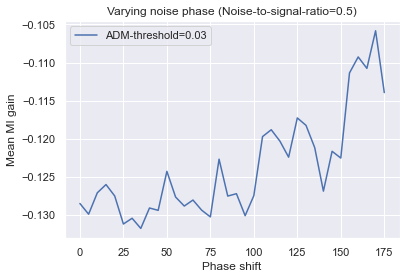

In [309]:
phis = np.arange(0, 180, 5)#np.linspace(1, 181, 20)
ADM_thresholds = [0.03, 0.05, 0.07]
noise_strength = 0.5
for ADM_threshold in ADM_thresholds:
    MI_gains = []
    for phi in phis:
        MI_gain = run_pipeline(phi=phi, noise_strength=noise_strength, ADM_threshold=ADM_threshold)
        MI_gains.append(MI_gain)
    plt.plot(phis, MI_gains, label='ADM-threshold='+str(ADM_threshold))
    plt.xlabel('Phase shift')
    plt.ylabel('Mean MI gain')
    plt.title('Varying noise phase (Noise-to-signal-ratio={})'.format(noise_strength))
    plt.legend()

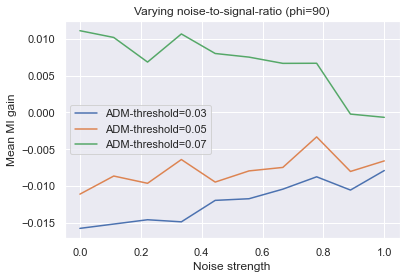

In [330]:
noise_strengths = np.linspace(0, 1, 10)
ADM_thresholds = [0.03, 0.05, 0.07]
noise_strength = 0.5
phi = 90
for ADM_threshold in ADM_thresholds:
    MI_gains = []
    for noise_strength in noise_strengths:
        MI_gain = run_pipeline(phi=phi, noise_strength=noise_strength, ADM_threshold=ADM_threshold)
        MI_gains.append(MI_gain)
    plt.plot(noise_strengths, MI_gains, label='ADM-threshold='+str(ADM_threshold))
    plt.xlabel('Noise strength')
    plt.ylabel('Mean MI gain')
    plt.title('Varying noise-to-signal-ratio (phi={})'.format(phi))
    plt.legend()

In [ ]:
MI_gains = []
ADM_thresholds = np.arange(0, 2, 0.01)
phase = 90
for ADM_threshold in ADM_thresholds:
    MI_gain = run_pipeline(phi=phase, noise_strength=0.5, ADM_threshold=ADM_threshold)
    MI_gains.append(MI_gain)
plt.plot(ADM_thresholds, MI_gains)
plt.xlabel('ADM threshold')
plt.ylabel('Mean MI gain')
plt.title('ADM threshold (Phase={})'.format(phase))

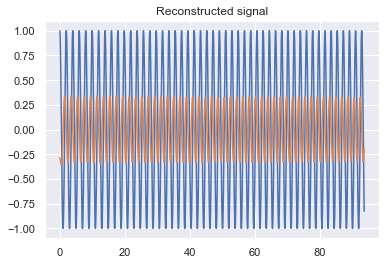

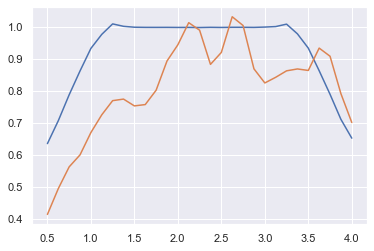

In [348]:
value = run_pipeline(phi=90, noise_strength=0, ADM_threshold=0.07, plot_MI=True, plot_rec=True, segment=6000)

In [349]:
value

-0.11630156470784336